## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

### Goals:
#### Use Scikit-Learn pipelines to define special features to add to a Naive Bayes Classifier
#### Evaluate the accuracy of the classifier
#### Maybe do it live, on a Twitter API stream

### Methods:
#### Use the training set I made before

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from textblob import TextBlob
from time import time, sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import json
import re

#### Set max column width for dataframes

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the CSV

In [4]:
df = pd.read_csv("../data/data_for_training/final_training_data/Subtweets_Classifier_Training_Data.csv")

#### Create training and test sets from the single training set I made before

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df.alleged_subtweet.tolist(), 
                                                                  df.is_subtweet.tolist())

#### Use NLTK's tokenizer instead of Scikit's

In [6]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Function for managing TextBlob polarities

In [7]:
def simplify_polarity(polarity):
    if polarity >= 0:
        return 1
    return 0

#### Class for distinguishing polarizing parts of speech as features

In [8]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        first_names = ["Aaliyah", "Aaron", "Abby", "Abigail", "Abraham", "Adam",
                       "Addison", "Adrian", "Adriana", "Adrianna", "Aidan", "Aiden",
                       "Alan", "Alana", "Alejandro", "Alex", "Alexa", "Alexander",
                       "Alexandra", "Alexandria", "Alexia", "Alexis", "Alicia", "Allison",
                       "Alondra", "Alyssa", "Amanda", "Amber", "Amelia", "Amy",
                       "Ana", "Andrea", "Andres", "Andrew", "Angel", "Angela",
                       "Angelica", "Angelina", "Anna", "Anthony", "Antonio", "Ariana",
                       "Arianna", "Ashley", "Ashlyn", "Ashton", "Aubrey", "Audrey",
                       "Austin", "Autumn", "Ava", "Avery", "Ayden", "Bailey",
                       "Benjamin", "Bianca", "Blake", "Braden", "Bradley", "Brady",
                       "Brandon", "Brayden", "Breanna", "Brendan", "Brian", "Briana",
                       "Brianna", "Brittany", "Brody", "Brooke", "Brooklyn", "Bryan",
                       "Bryce", "Bryson", "Caden", "Caitlin", "Caitlyn", "Caleb",
                       "Cameron", "Camila", "Carlos", "Caroline", "Carson", "Carter",
                       "Cassandra", "Cassidy", "Catherine", "Cesar", "Charles", "Charlotte",
                       "Chase", "Chelsea", "Cheyenne", "Chloe", "Christian", "Christina",
                       "Christopher", "Claire", "Cody", "Colby", "Cole", "Colin",
                       "Collin", "Colton", "Conner", "Connor", "Cooper", "Courtney",
                       "Cristian", "Crystal", "Daisy", "Dakota", "Dalton", "Damian",
                       "Daniel", "Daniela", "Danielle", "David", "Delaney", "Derek",
                       "Destiny", "Devin", "Devon", "Diana", "Diego", "Dominic",
                       "Donovan", "Dylan", "Edgar", "Eduardo", "Edward", "Edwin",
                       "Eli", "Elias", "Elijah", "Elizabeth", "Ella", "Ellie", 
                       "Emily", "Emma", "Emmanuel", "Eric", "Erica", "Erick",
                       "Erik", "Erin", "Ethan", "Eva", "Evan", "Evelyn",
                       "Faith", "Fernando", "Francisco", "Gabriel", "Gabriela", "Gabriella",
                       "Gabrielle", "Gage", "Garrett", "Gavin", "Genesis", "George",
                       "Gianna", "Giovanni", "Giselle", "Grace", "Gracie", "Grant",
                       "Gregory", "Hailey", "Haley", "Hannah", "Hayden", "Hector",
                       "Henry", "Hope", "Hunter", "Ian", "Isaac", "Isabel",
                       "Isabella", "Isabelle", "Isaiah", "Ivan", "Jack", "Jackson",
                       "Jacob", "Jacqueline", "Jada", "Jade", "Jaden", "Jake",
                       "Jalen", "James", "Jared", "Jasmin", "Jasmine", "Jason", 
                       "Javier", "Jayden", "Jayla", "Jazmin", "Jeffrey", "Jenna",
                       "Jennifer", "Jeremiah", "Jeremy", "Jesse", "Jessica", "Jesus",
                       "Jillian", "Jocelyn", "Joel", "John", "Johnathan", "Jonah",
                       "Jonathan", "Jordan", "Jordyn", "Jorge", "Jose", "Joseph",
                       "Joshua", "Josiah", "Juan", "Julia", "Julian", "Juliana",
                       "Justin", "Kaden", "Kaitlyn", "Kaleb", "Karen", "Karina",
                       "Kate", "Katelyn", "Katherine", "Kathryn", "Katie", "Kayla",
                       "Kaylee", "Kelly", "Kelsey", "Kendall", "Kennedy", "Kenneth",
                       "Kevin", "Kiara", "Kimberly", "Kyle", "Kylee", "Kylie",
                       "Landon", "Laura", "Lauren", "Layla", "Leah", "Leonardo",
                       "Leslie", "Levi", "Liam", "Liliana", "Lillian", "Lilly",
                       "Lily", "Lindsey", "Logan", "Lucas", "Lucy", "Luis",
                       "Luke", "Lydia", "Mackenzie", "Madeline", "Madelyn", "Madison",
                       "Makayla", "Makenzie", "Malachi", "Manuel", "Marco", "Marcus",
                       "Margaret", "Maria", "Mariah", "Mario", "Marissa", "Mark",
                       "Martin", "Mary", "Mason", "Matthew", "Max", "Maxwell",
                       "Maya", "Mckenzie", "Megan", "Melanie", "Melissa", "Mia",
                       "Micah", "Michael", "Michelle", "Miguel", "Mikayla", "Miranda",
                       "Molly", "Morgan", "Mya", "Naomi", "Natalia", "Natalie",
                       "Nathan", "Nathaniel", "Nevaeh", "Nicholas", "Nicolas", "Nicole",
                       "Noah", "Nolan", "Oliver", "Olivia", "Omar", "Oscar",
                       "Owen", "Paige", "Parker", "Patrick", "Paul", "Payton",
                       "Peter", "Peyton", "Preston", "Rachel", "Raymond", "Reagan",
                       "Rebecca", "Ricardo", "Richard", "Riley", "Robert", "Ruby",
                       "Ryan", "Rylee", "Sabrina", "Sadie", "Samantha", "Samuel",
                       "Sara", "Sarah", "Savannah", "Sean", "Sebastian", "Serenity",
                       "Sergio", "Seth", "Shane", "Shawn", "Shelby", "Sierra",
                       "Skylar", "Sofia", "Sophia", "Sophie", "Spencer", "Stephanie",
                       "Stephen", "Steven", "Summer", "Sydney", "Tanner", "Taylor", 
                       "Thomas", "Tiffany", "Timothy", "Travis", "Trenton", "Trevor",
                       "Trinity", "Tristan", "Tyler", "Valeria", "Valerie", "Vanessa",
                       "Veronica", "Victor", "Victoria", "Vincent", "Wesley", "William",
                       "Wyatt", "Xavier", "Zachary", "Zoe", "Zoey"]
        first_names_lower = set([name.lower() for name in first_names])

        pronouns = ["You", "You're", "Your", 
                    "She", "She's", "Her", "Hers", 
                    "He", "He's", "Him", "His", 
                    "They", "They're", "Them", "Their", "Theirs"]
        prounouns_lower = set([pronoun.lower() for pronoun in pronouns])
        
        first_person_pronouns = ["I", "I'm", "We", "We're", "Our", "My", "Us"]
        first_person_pronouns_lower = set([pronoun.lower() for pronoun in first_person_pronouns])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_pronouns = len(prounouns_lower.intersection(tokenized_text))
            num_names = len(first_names_lower.intersection(tokenized_text))
            num_first_person = len(first_person_pronouns_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            
            weighted_dict = {"sentiment": simplify_polarity(TextBlob(text).sentiment.polarity), 
                             "num_subtweet": num_subtweet,
                             "num_at_symbols": num_at_symbols, 
                             "num_urls": num_urls,
                             "num_pronouns": num_pronouns,
                             "num_names": num_names, 
                             "num_first_person": num_first_person, 
                             "num_at_symbols": num_at_symbols,
                             "num_subtweet": num_subtweet,
                             "num_urls": num_urls}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [9]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [10]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [11]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.97      0.86      0.91      1397
   positive       0.87      0.97      0.92      1381

avg / total       0.92      0.91      0.91      2778



#### Define function for visualizing confusion matrices

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

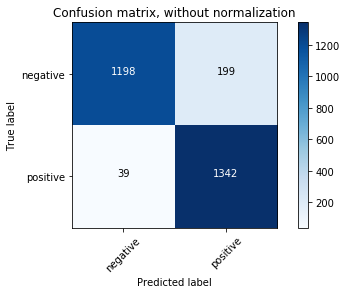

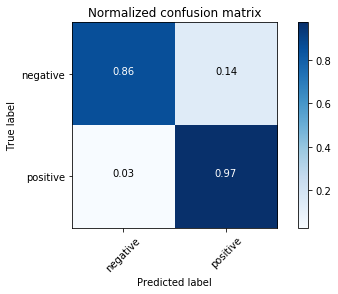

In [13]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [14]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl") 

['../data/other_data/subtweets_classifier.pkl']

#### Print tests for the classifier

In [15]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [16]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [17]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [18]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
0,None,0.044404,0.955596,Some people don't know their place.
1,None,0.052663,0.947337,Isn't it funny how some people don't know their place?
2,None,0.108819,0.891181,How come you people act like this?
3,None,0.176988,0.823012,You're such a nerd.
4,None,0.251143,0.748857,"I love Noah, he's so cool."


#### Test on actual tweets

In [19]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [20]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [21]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [22]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [23]:
print("Length of dataset: {}".format(len(naji_df)))

Length of dataset: 1564156


#### Use randomly selected 50K rows from dataset

In [24]:
naji_df = naji_df.sample(n=50000).reset_index(drop=True)

#### Print and time the tests

In [25]:
%%time
naji_df = tests_dataframe(naji_df)

CPU times: user 45.1 s, sys: 746 ms, total: 45.8 s
Wall time: 53 s


In [26]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

In [27]:
naji_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
13817,0,0.003028,0.996972,You never really realize how much of an impact someone has on your daily life until all their stuff is packed and they are gone.
38866,0,0.005830,0.994170,how do you remove followers from your actual followers list? blocked them but they ARE STILL THERE
41007,0,0.006756,0.993244,"I hate how you can't hang around your 'guy friends' cuz they always want a guys night together, minus you. Cuz you're not a guy"
23775,0,0.007760,0.992240,i guess its true- once your dating someone then all the guys ask you out and flirt- but when you are single they all STOP
40976,0,0.008600,0.991400,Why when your anticipating something the weeks drag on so slow?& when you want them to go slow they fly by


#### Plot the results

In [28]:
naji_df_columns = ["sentiment_score", "subtweet_negative_probability"]

In [29]:
naji_df = naji_df.set_index("tweet").drop(naji_df_columns, axis=1).head(10)

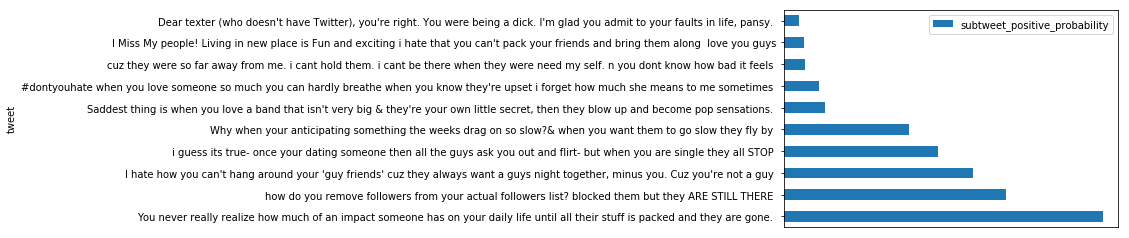

In [30]:
naji_df.plot.barh(logx=True);

#### Tests on friends' tweets

In [31]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [32]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 3.17 s, sys: 53.7 ms, total: 3.22 s
Wall time: 3.65 s


In [33]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [34]:
aaron_df["tweet"] = aaron_df["tweet"].str[:140]

In [35]:
aaron_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1722,None,0.006081,0.993919,"PewDiePie posts video ""apologizing"" for his Kill All Jews ""joke"" and it's really about how he makes a ton of money and the media hates him"
3283,None,0.006190,0.993810,"It's funny because he blocked our whole family on facebook (you can find him if you log out) and insists he ""doesn't use it"""
3281,None,0.007563,0.992437,What he doesn't know (unless he stalks my twitter which I know he does) is that I have fake accounts following all his social media
2893,None,0.007570,0.992430,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
3236,None,0.008416,0.991584,"What will straight cis people do now with their ""legalize gay"" shirts? Frame them, probably"


#### Plot the results

In [36]:
aaron_df_columns = ["sentiment_score", "subtweet_negative_probability"]

In [37]:
aaron_df = aaron_df.set_index("tweet").drop(aaron_df_columns, axis=1).head(10)

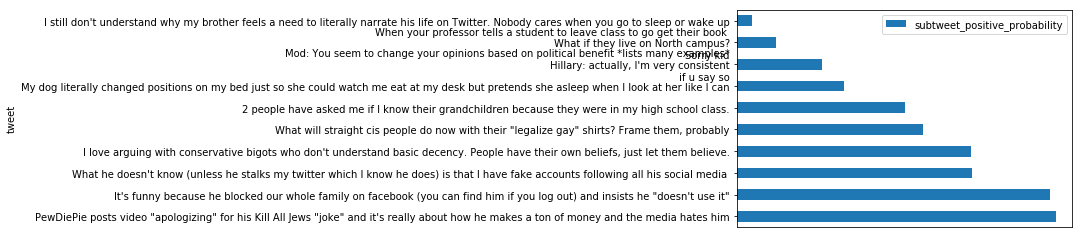

In [38]:
aaron_df.plot.barh(logx=True);

In [39]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [40]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 6.04 s, sys: 91.4 ms, total: 6.13 s
Wall time: 6.88 s


In [41]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [42]:
julia_df["tweet"] = julia_df["tweet"].str[:140]

In [43]:
julia_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1138,None,0.002422,0.997578,"""what a COINcidence that you're here,"" drawls Bitcoin lustily. your palms sweat as you imagine what it would be like to own this creature, t"
902,None,0.004004,0.995996,tbh if they don't start publically dating in a year after pyeongchang I'm going to be S H O C K E D how can you look at somebody like that i
850,None,0.005445,0.994555,honestly they should be I can't believe they're even considered such high threats to tessa and scott on their underwhelming lifts alone
770,None,0.005526,0.994474,"what are these people SEEING in them that's so wonderful??? I don't know how people can justify their technical inferiority by saying ""oh, t"
236,None,0.005698,0.994302,"look I've been thinking about it and even if they're older and less able to perform (although, they're at the top of their game now) they co"


#### Plot the results

In [44]:
julia_df_columns = ["sentiment_score", "subtweet_negative_probability"]

In [45]:
julia_df = julia_df.set_index("tweet").drop(julia_df_columns, axis=1).head(10)

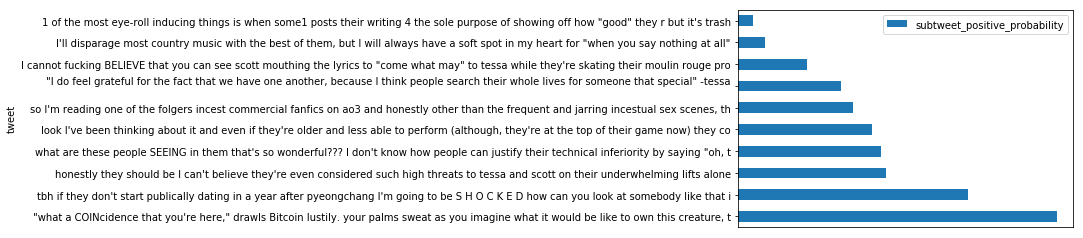

In [46]:
julia_df.plot.barh(logx=True);

In [47]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [48]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.16 s, sys: 20.9 ms, total: 1.18 s
Wall time: 1.37 s


In [49]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [50]:
zoe_df["tweet"] = zoe_df["tweet"].str[:140]

In [51]:
zoe_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
277,None,0.005355,0.994645,ok so people from my old school keep lamenting the death of someone to whom they claim to be close but also like continually misgender them
584,None,0.007600,0.992400,the funny thing about anxiety is one minute you could be playing one of your favorite tabletop games w some of your favorite people and then
583,None,0.013254,0.986746,and u decide to tweet about it weeks later bc no one ever talked about it and ur anxious mind decided 2 interpret that as no one caring when
334,None,0.017399,0.982601,"Literally every time one of us little people makes a tweet that gets popular one of our friends HAS to comment ""don't forget us little peopl"
1105,None,0.018083,0.981917,"The guy who had the audacity to write a Buzzfeed ""article"" called ""28 problems only ridiculously good looking people have"" thinks he's ridic"


#### Plot the results

In [52]:
zoe_df_columns = ["sentiment_score", "subtweet_negative_probability"]

In [53]:
zoe_df = zoe_df.set_index("tweet").drop(zoe_df_columns, axis=1).head(10)

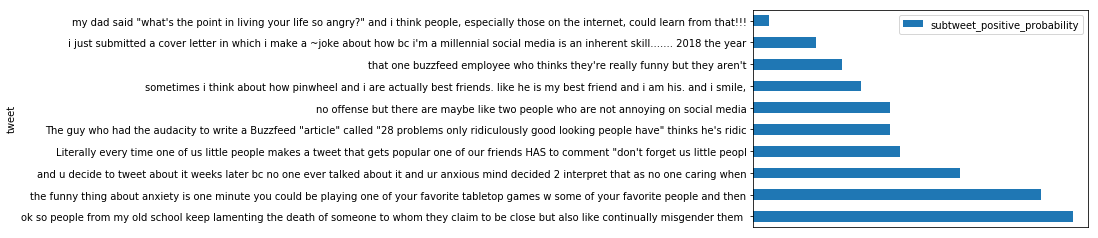

In [54]:
zoe_df.plot.barh(logx=True);

In [55]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [56]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 3.92 s, sys: 66.5 ms, total: 3.99 s
Wall time: 4.63 s


In [57]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [58]:
noah_df["tweet"] = noah_df["tweet"].str[:140]

In [59]:
noah_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
877,None,0.003053,0.996947,I guess I think it’s foolish to rely on any website for being your source of personal fulfillment and especially as your only source for pol
3525,None,0.004462,0.995538,some people want their kids to take care of them when they are elderly but I plan to enslave sentient AI to do that for me until the end.
845,None,0.005960,0.994040,"my plan to watch list has 224 entires! that is one of them! I treat all my children equally and fairly, and they will each be given their du"
379,None,0.008052,0.991948,The washer on the far left of the Robbins laundry room won’t start unless you press the start button really hard and someone forgot to start
1777,None,0.008098,0.991902,I feel like being able to tweet twice as many characters is a nice addition but I wonder about the priorities of the platforms we use. The w


#### Plot the results

In [60]:
noah_df_columns = ["sentiment_score", "subtweet_negative_probability"]

In [61]:
noah_df = noah_df.set_index("tweet").drop(noah_df_columns, axis=1).head(10)

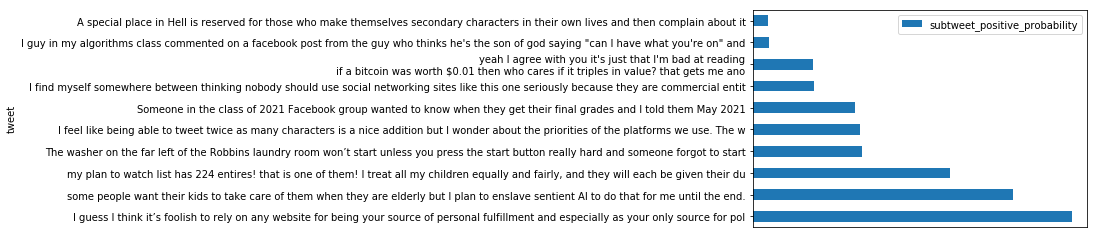

In [62]:
noah_df.plot.barh(logx=True);

#### Test it in realtime
#### Define some useful variables for later

In [63]:
THRESHOLD = 0.925 # 92.5% positives and higher, only
DURATION = 60*60*12 # 12 hours

#### Load Twitter API credentials

In [64]:
consumer_key, consumer_secret, access_token, access_token_secret = open("../../credentials.txt").read().split("\n")

#### Use the API credentials to connect to the API

In [65]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, retry_delay=1, timeout=120, # 2 minutes
                 compression=True, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Prepare the final dataframe

In [66]:
subtweets_live_list = []
non_subtweets_live_list = []

#### Create a custom class for streaming subtweets

In [67]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        text = status.text
        text = text.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<")
        
        # negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        
        screen_name = status.user.screen_name
        created_at = status.created_at
        
        sentiment = TextBlob(text).sentiment
        
        sentiment_polarity = sentiment.polarity
        sentiment_subjectivity = sentiment.subjectivity
        
        row = {"tweet": text, 
               "screen_name": screen_name, 
               "time": created_at, 
               "subtweet_probability": positive_probability, 
               "sentiment_polarity": sentiment_polarity, 
               "sentiment_subjectivity": sentiment_subjectivity}
        print_list = pd.DataFrame([row]).values.tolist()[0]
        
        if all([positive_probability >= THRESHOLD,
                not status.retweeted,
                "RT @" not in text, 
                not status.in_reply_to_status_id]):
            
            api.update_status("{:.1%} \nhttps://twitter.com/{}/status/{}".format(positive_probability, 
                                                                                 screen_name, 
                                                                                 status.id))
            
            subtweets_live_list.append(row)
            subtweets_df = pd.DataFrame(subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                         ascending=False)
            subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv")
            
            print("Subtweet:\n{}\nGeographical Bounding Box: {}\nTotal tweets acquired: {}\n".format(str(print_list)[1:-1],
                                                                                                     None,
                                                                                                     # status.place.bounding_box.coordinates, 
                                                                                                     (len(subtweets_live_list) + len(non_subtweets_live_list))))
            
            return row
        else:
            non_subtweets_live_list.append(row)
            non_subtweets_df = pd.DataFrame(non_subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                                 ascending=False)
            non_subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/non_subtweets_live_data.csv")
            
            # print("Not a Subtweet:\n{}\nTotal tweets acquired: {}\n".format(print_list, len(subtweets_live_list) + len(non_subtweets_live_list)))
            return row

#### Get a list of the IDs of all my mutuals and my mutuals' followers

In [68]:
%%time
my_followers = [str(user_id) for ids_list in 
                tweepy.Cursor(api.followers_ids, 
                              screen_name="NoahSegalGould").pages() 
                for user_id in ids_list]
users_i_follow = [str(user_id) for ids_list in 
                  tweepy.Cursor(api.friends_ids, 
                                screen_name="NoahSegalGould").pages() 
                  for user_id in ids_list]

mutuals = list(set(my_followers) & set(users_i_follow))

my_mutuals = mutuals[:]
for i, mutual in enumerate(mutuals):
    start_time = time()
    user = api.get_user(user_id=mutual)
    if not user.protected:
        individual_mutuals_followers = []
        c = tweepy.Cursor(api.followers_ids, user_id=mutual).items()
        while True:
            try:
                individual_mutuals_follower = c.next()
                individual_mutuals_followers.append(str(individual_mutuals_follower))
            except tweepy.TweepError:
                sleep(600) # 10 minutes
                continue
            except StopIteration:
                break
        total = len(individual_mutuals_followers)
        name = user.screen_name
        print("{} followers for mutual {}: {}".format(total, i+1, name))
        if total <= 2500:
            my_mutuals.extend(individual_mutuals_followers)
        else:
            print("\tMutual {0}: {1} has too many followers: {2}".format(i+1, name, total))
    else:
        continue
    end_time = time()
    with open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Followers_ids.json", "w") as outfile:
        json.dump(my_mutuals, outfile)
    print("{0:.2f} seconds for getting the followers' IDs of mutual {1}: {2}\n".format((end_time - start_time), 
                                                                                       i+1, user.screen_name))
    sleep(5)
my_mutuals = list(set(my_mutuals))

77 followers for mutual 1: cleostaryeyed
0.72 seconds for getting the followers' IDs of mutual 1: cleostaryeyed

3 followers for mutual 2: 1017hokage
0.74 seconds for getting the followers' IDs of mutual 2: 1017hokage

25 followers for mutual 4: BardCourses
0.75 seconds for getting the followers' IDs of mutual 4: BardCourses

33 followers for mutual 5: beachaliens
0.72 seconds for getting the followers' IDs of mutual 5: beachaliens

45 followers for mutual 6: valunept
0.80 seconds for getting the followers' IDs of mutual 6: valunept

393 followers for mutual 7: bluhoopz
0.78 seconds for getting the followers' IDs of mutual 7: bluhoopz

34 followers for mutual 9: plurell
0.70 seconds for getting the followers' IDs of mutual 9: plurell

14 followers for mutual 10: zozotherobo
2.71 seconds for getting the followers' IDs of mutual 10: zozotherobo

66 followers for mutual 11: katie_burke_
0.77 seconds for getting the followers' IDs of mutual 11: katie_burke_

128 followers for mutual 13: ev

Rate limit reached. Sleeping for: 813


153 followers for mutual 19: Garrettisajoke
1476.71 seconds for getting the followers' IDs of mutual 19: Garrettisajoke

50 followers for mutual 20: andrewdjang
0.69 seconds for getting the followers' IDs of mutual 20: andrewdjang

228 followers for mutual 21: Pumpkinheadgal
0.74 seconds for getting the followers' IDs of mutual 21: Pumpkinheadgal

180 followers for mutual 22: Tageist97
0.71 seconds for getting the followers' IDs of mutual 22: Tageist97

45 followers for mutual 23: itsnemily
0.75 seconds for getting the followers' IDs of mutual 23: itsnemily

92 followers for mutual 25: UpToneMusic
0.69 seconds for getting the followers' IDs of mutual 25: UpToneMusic

204 followers for mutual 26: sycamorethrone
0.75 seconds for getting the followers' IDs of mutual 26: sycamorethrone

332 followers for mutual 29: real_john_wilks
0.68 seconds for getting the followers' IDs of mutual 29: real_john_wilks

31055 followers for mutual 30: extrafabulous
	Mutual 30: extrafabulous has too many fo

Rate limit reached. Sleeping for: 845


172 followers for mutual 31: Meg_Murph26
1501.64 seconds for getting the followers' IDs of mutual 31: Meg_Murph26

152 followers for mutual 32: dramallama_x3
0.74 seconds for getting the followers' IDs of mutual 32: dramallama_x3

140 followers for mutual 33: akrapf96
0.69 seconds for getting the followers' IDs of mutual 33: akrapf96

27 followers for mutual 34: TannerCohan
0.70 seconds for getting the followers' IDs of mutual 34: TannerCohan

174 followers for mutual 36: FearlessFierlit
0.71 seconds for getting the followers' IDs of mutual 36: FearlessFierlit

16 followers for mutual 38: ARKB0T
0.70 seconds for getting the followers' IDs of mutual 38: ARKB0T

345 followers for mutual 39: KayleeSue
0.69 seconds for getting the followers' IDs of mutual 39: KayleeSue

90 followers for mutual 40: christinabeenas
0.71 seconds for getting the followers' IDs of mutual 40: christinabeenas

182 followers for mutual 41: Momose_13
0.68 seconds for getting the followers' IDs of mutual 41: Momose_

Rate limit reached. Sleeping for: 813


25 followers for mutual 48: motherbored3017
1472.43 seconds for getting the followers' IDs of mutual 48: motherbored3017

289 followers for mutual 49: jaypatricksmith
0.72 seconds for getting the followers' IDs of mutual 49: jaypatricksmith

116 followers for mutual 50: Oblivion_Mag
0.77 seconds for getting the followers' IDs of mutual 50: Oblivion_Mag

347 followers for mutual 51: graysonjmorley
0.72 seconds for getting the followers' IDs of mutual 51: graysonjmorley

45 followers for mutual 52: jmzaccagnino
1.34 seconds for getting the followers' IDs of mutual 52: jmzaccagnino

29 followers for mutual 53: wdya0
1.73 seconds for getting the followers' IDs of mutual 53: wdya0

53 followers for mutual 54: KaiMalowany
0.74 seconds for getting the followers' IDs of mutual 54: KaiMalowany

20 followers for mutual 55: Terrible_Goose
0.74 seconds for getting the followers' IDs of mutual 55: Terrible_Goose

52 followers for mutual 56: level99andahalf
1.40 seconds for getting the followers' ID

Rate limit reached. Sleeping for: 810


163 followers for mutual 63: duheiii
1478.33 seconds for getting the followers' IDs of mutual 63: duheiii

218 followers for mutual 64: forgotlogininfo
0.75 seconds for getting the followers' IDs of mutual 64: forgotlogininfo

406 followers for mutual 65: keithohara
0.85 seconds for getting the followers' IDs of mutual 65: keithohara

28 followers for mutual 66: PieterFildes
0.76 seconds for getting the followers' IDs of mutual 66: PieterFildes

6 followers for mutual 67: KenCooperBot
0.76 seconds for getting the followers' IDs of mutual 67: KenCooperBot

154 followers for mutual 68: Maxiscoffee
0.81 seconds for getting the followers' IDs of mutual 68: Maxiscoffee

17 followers for mutual 69: hydrothermal_
0.98 seconds for getting the followers' IDs of mutual 69: hydrothermal_

192 followers for mutual 70: ahung23
0.71 seconds for getting the followers' IDs of mutual 70: ahung23

2 followers for mutual 71: nedcoz
0.75 seconds for getting the followers' IDs of mutual 71: nedcoz

34 foll

Rate limit reached. Sleeping for: 812


387 followers for mutual 79: whoisleormiller
1471.52 seconds for getting the followers' IDs of mutual 79: whoisleormiller

157 followers for mutual 80: por_eleanor
0.76 seconds for getting the followers' IDs of mutual 80: por_eleanor

1 followers for mutual 81: anaturalnumber
0.79 seconds for getting the followers' IDs of mutual 81: anaturalnumber

75 followers for mutual 82: h0tsccrgirl1996
0.73 seconds for getting the followers' IDs of mutual 82: h0tsccrgirl1996

33 followers for mutual 83: UpToneOfficial
0.81 seconds for getting the followers' IDs of mutual 83: UpToneOfficial

71 followers for mutual 84: AdamMuhsin
0.79 seconds for getting the followers' IDs of mutual 84: AdamMuhsin

81 followers for mutual 85: metalgarurumonz
0.81 seconds for getting the followers' IDs of mutual 85: metalgarurumonz

98 followers for mutual 86: lisasimpsonstan
0.74 seconds for getting the followers' IDs of mutual 86: lisasimpsonstan

499 followers for mutual 87: cmands
0.76 seconds for getting the f

Rate limit reached. Sleeping for: 813


5 followers for mutual 94: jeffdaugherty15
1486.74 seconds for getting the followers' IDs of mutual 94: jeffdaugherty15

2 followers for mutual 95: RogerAlmonds
0.77 seconds for getting the followers' IDs of mutual 95: RogerAlmonds

252 followers for mutual 96: cassy_savs
0.80 seconds for getting the followers' IDs of mutual 96: cassy_savs

36 followers for mutual 97: TheCzarchitect
0.73 seconds for getting the followers' IDs of mutual 97: TheCzarchitect

163 followers for mutual 98: carsonscabinet
0.74 seconds for getting the followers' IDs of mutual 98: carsonscabinet

218 followers for mutual 99: zoeterhune
0.76 seconds for getting the followers' IDs of mutual 99: zoeterhune

435 followers for mutual 100: stfwlkr
0.72 seconds for getting the followers' IDs of mutual 100: stfwlkr

325 followers for mutual 101: scorpiodisaster
0.81 seconds for getting the followers' IDs of mutual 101: scorpiodisaster

15 followers for mutual 102: maggersmay
0.75 seconds for getting the followers' IDs 

Rate limit reached. Sleeping for: 812


1 followers for mutual 109: robyn53966273
1539.18 seconds for getting the followers' IDs of mutual 109: robyn53966273

CPU times: user 5.91 s, sys: 1.38 s, total: 7.29 s
Wall time: 3h 3min 26s


In [69]:
print("Total number of my mutuals: {}".format(len(mutuals)))

Total number of my mutuals: 109


In [70]:
print("Total number of my mutuals' followers: {}".format(len(my_mutuals) - len(mutuals)))

Total number of my mutuals' followers: 11682


#### Instantiate the listener

In [71]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [ ]:
%%time
# bounding_box = [-73.920176, 42.009637,
#                 -73.899739, 42.033421]http://localhost:8888/notebooks/development/classifier_creator.ipynb#
# stream.filter(locations=bounding_box, async=True) # Bard College
stream.filter(follow=my_mutuals, async=True)
print("Columns:")
print("screen_name, sentiment_polarity, sentiment_subjectivity, subtweet_probability, time, text")
sleep(DURATION)
stream.disconnect()

#### Plot the results

In [73]:
subtweets_df = pd.read_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv", index_col=0)

In [74]:
subtweets_df["tweet"] = subtweets_df["tweet"].str[:140]

In [75]:
subtweets_df_columns = ["screen_name", "time"]

In [76]:
subtweets_df = subtweets_df.set_index("tweet").drop(subtweets_df_columns, axis=1).head(10)

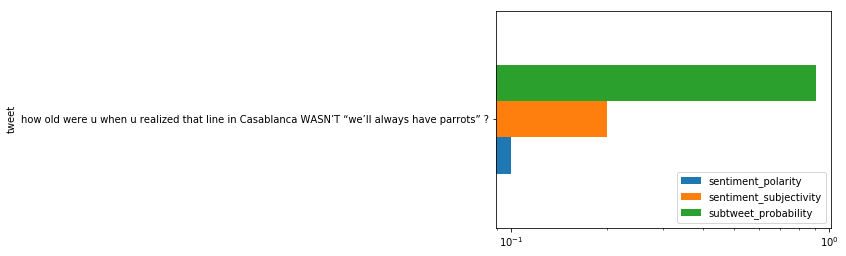

In [77]:
subtweets_df.plot.barh(logx=True);